In [ ]:
# default_exp examples.glue

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# GLUE  classification tasks

> This notebook demonstrates how we can use Blurr to tackle the [General Language Understanding Evaluation(GLUE) benchmark](https://gluebenchmark.com/) tasks.

In [ ]:
#export
import torch
from fastai.text.all import *

from datasets import load_dataset, concatenate_datasets
from transformers import *

from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

logging.set_verbosity_error()

In [ ]:
#hide_input
import pdb

from fastcore.test import *
from nbverbose.showdoc import show_doc

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("Here's what we're running with ...\n")
print_versions('torch fastai transformers')

torch: 1.7.1
fastai: 2.5.0
transformers: 4.9.2


In [ ]:
#cuda
#hide_input
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## GLUE tasks

In [ ]:
#hide_input
glue_tasks = {
    'cola': {
        'abbr': 'CoLA',
        'name': 'Corpus of Linguistic Acceptability',
        'description': 'Predict whether a sequence is a grammatical English sentence',
        'task_type': 'Single-Sentence Task',
        'domain': 'Misc.',
        'size': '8.5k',
        'metrics': 'Matthews corr.',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['sentence'],
        'target': 'label',
        'metric_funcs': [MatthewsCorrCoef()],
        'n_labels': 2,
    },
    'sst2': {
        'abbr': 'SST-2',
        'name': 'Stanford Sentiment Treebank',
        'description': 'Predict the sentiment of a given sentence',
        'task_type': 'Single-Sentence Task',
        'domain': 'Movie reviews',
        'size': '67k',
        'metrics': 'Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['sentence'],
        'target': 'label',
        'metric_funcs': [accuracy],
        'n_labels': 2
    },
    
    'mrpc': {
        'abbr': 'MRPC',
        'name': 'Microsoft Research Paraphrase Corpus',
        'description': 'Predict whether two sentences are semantically equivalent',
        'task_type': 'Similarity and Paraphrase Tasks',
        'domain': 'News',
        'size': '3.7k',
        'metrics': 'F1/Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['sentence1', 'sentence2'],
        'target': 'label',
        'metric_funcs': [F1Score(), accuracy],
        'n_labels': 2
    },
    'stsb': {
        'abbr': 'SST-B',
        'name': 'Semantic Textual Similarity Benchmark',
        'description': 'Predict the similarity score for two sentences on a scale from 1 to 5',
        'task_type': 'Similarity and Paraphrase Tasks',
        'domain': 'Misc.',
        'size': '7k',
        'metrics': 'Pearson/Spearman corr.',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['sentence1', 'sentence2'],
        'target': 'label',
        'metric_funcs': [PearsonCorrCoef(), SpearmanCorrCoef()],
        'n_labels': 1
    },
    'qqp': {
        'abbr': 'QQP',
        'name': 'Quora question pair',
        'description': 'Predict if two questions are a paraphrase of one another',
        'task_type': 'Similarity and Paraphrase Tasks',
        'domain': 'Social QA questions',
        'size': '364k',
        'metrics': 'F1/Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['question1', 'question2'],
        'target': 'label',
        'metric_funcs': [F1Score(), accuracy],
        'n_labels': 2
    },
    
    'mnli': {
        'abbr': 'MNLI',
        'name': 'Mulit-Genre Natural Language Inference',
        'description': 'Predict whether the premise entails, contradicts or is neutral to the hypothesis',
        'task_type': 'Inference Tasks',
        'domain': 'Misc.',
        'size': '393k',
        'metrics': 'Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation-matched', 'test': 'test'},
        'inputs': ['premise', 'hypothesis'],
        'target': 'label',
        'metric_funcs': [accuracy],
        'n_labels': 3
    },
    'qnli': {
        'abbr': 'QNLI',
        'name': 'Stanford Question Answering Dataset',
        'description': 'Predict whether the context sentence contains the answer to the question',
        'task_type': 'Inference Tasks',
        'domain': 'Wikipedia',
        'size': '105k',
        'metrics': 'Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['question', 'sentence'],
        'target': 'label',
        'metric_funcs': [accuracy],
        'n_labels': 2
    },
    'rte': {
        'abbr': 'RTE',
        'name': 'Recognize Textual Entailment',
        'description': 'Predict whether one sentece entails another',
        'task_type': 'Inference Tasks',
        'domain': 'News, Wikipedia',
        'size': '2.5k',
        'metrics': 'Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['sentence1', 'sentence2'],
        'target': 'label',
        'metric_funcs': [accuracy],
        'n_labels': 2
    },
    'wnli': {
        'abbr': 'WNLI',
        'name': 'Winograd Schema Challenge',
        'description': 'Predict if the sentence with the pronoun substituted is entailed by the original sentence',
        'task_type': 'Inference Tasks',
        'domain': 'Fiction books',
        'size': '634',
        'metrics': 'Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['sentence1', 'sentence2'],
        'target': 'label',
        'metric_funcs': [accuracy],
        'n_labels': 2
    }
}

# for v in glue_tasks.values(): print(v)
glue_tasks.values()

glue_df = pd.DataFrame(glue_tasks.values(), columns=['abbr', 'name', 'task_type', 'description', 'size', 'metrics'])
glue_df.columns = glue_df.columns.str.replace('_', ' ').str.capitalize()
glue_df.style.hide_index()

Abbr,Name,Task type,Description,Size,Metrics
CoLA,Corpus of Linguistic Acceptability,Single-Sentence Task,Predict whether a sequence is a grammatical English sentence,8.5k,Matthews corr.
SST-2,Stanford Sentiment Treebank,Single-Sentence Task,Predict the sentiment of a given sentence,67k,Accuracy
MRPC,Microsoft Research Paraphrase Corpus,Similarity and Paraphrase Tasks,Predict whether two sentences are semantically equivalent,3.7k,F1/Accuracy
SST-B,Semantic Textual Similarity Benchmark,Similarity and Paraphrase Tasks,Predict the similarity score for two sentences on a scale from 1 to 5,7k,Pearson/Spearman corr.
QQP,Quora question pair,Similarity and Paraphrase Tasks,Predict if two questions are a paraphrase of one another,364k,F1/Accuracy
MNLI,Mulit-Genre Natural Language Inference,Inference Tasks,"Predict whether the premise entails, contradicts or is neutral to the hypothesis",393k,Accuracy
QNLI,Stanford Question Answering Dataset,Inference Tasks,Predict whether the context sentence contains the answer to the question,105k,Accuracy
RTE,Recognize Textual Entailment,Inference Tasks,Predict whether one sentece entails another,2.5k,Accuracy
WNLI,Winograd Schema Challenge,Inference Tasks,Predict if the sentence with the pronoun substituted is entailed by the original sentence,634,Accuracy


## Define the task and hyperparmeters

We'll use the "distilroberta-base" checkpoint for this example, but if you want to try an architecture that returns `token_type_ids` for example, you can use something like bert-cased.

In [ ]:
task = 'mrpc'
task_meta = glue_tasks[task]
train_ds_name = task_meta['dataset_names']["train"]
valid_ds_name = task_meta['dataset_names']["valid"]
test_ds_name = task_meta['dataset_names']["test"]

task_inputs =  task_meta['inputs']
task_target =  task_meta['target']
task_metrics = task_meta['metric_funcs']

pretrained_model_name = "distilroberta-base" # bert-base-cased | distilroberta-base

bsz = 16
val_bsz = bsz *2

## Prepare the datasets

Let's start by building our `DataBlock`.  We'll load the MRPC datset from huggingface's `datasets` library which will be cached after downloading via the `load_dataset` method.  For more information on the `datasets` API, see the documentation here.

In [ ]:
raw_datasets = load_dataset('glue', task) 
print(f'{raw_datasets}\n')
print(f'{raw_datasets[train_ds_name][0]}\n')
print(f'{raw_datasets[train_ds_name].features}\n')

Reusing dataset glue (/home/wgilliam/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

{'idx': 0, 'label': 1, 'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .'}

{'sentence1': Value(dtype='string', id=None), 'sentence2': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['not_equivalent', 'equivalent'], names_file=None, id=None), 'idx': Value(dtype='int32', id=None)}



There are a variety of ways we can preprocess the dataset for DataBlock consumption.  For example, we could push the data into a DataFrame, add a boolean `is_valid` column, and use the `ColSplitter` method to define our train/validation splits like this:

In [ ]:
raw_train_df = pd.DataFrame(raw_datasets[train_ds_name], columns=list(raw_datasets[train_ds_name].features.keys()))
raw_train_df['is_valid'] = False

raw_valid_df = pd.DataFrame(raw_datasets[valid_ds_name], columns=list(raw_datasets[train_ds_name].features.keys()))
raw_valid_df['is_valid'] = True

raw_df = pd.concat([raw_train_df, raw_valid_df])
print(len(raw_df))
raw_df.head()

4076


,sentence1,sentence2,label,idx,is_valid
0,"Amrozi accused his brother , whom he called "" the witness "" , of deliberately distorting his evidence .","Referring to him as only "" the witness "" , Amrozi accused his brother of deliberately distorting his evidence .",1,0,False
1,Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .,Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .,0,1,False
2,"They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .","On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale .",1,2,False
3,"Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .","Tab shares jumped 20 cents , or 4.6 % , to set a record closing high at A $ 4.57 .",0,3,False
4,"The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .",PG & E Corp. shares jumped $ 1.63 or 8 percent to $ 21.03 on the New York Stock Exchange on Friday .,1,4,False


Another option is to capture the indexes for both train and validation sets, use the datasets `concatenate_datasets` to put them into a single dataset, and finally use the `IndexSplitter` method to define our train/validation splits as such:

In [ ]:
n_train, n_valid = raw_datasets[train_ds_name].num_rows, raw_datasets[valid_ds_name].num_rows
train_idxs, valid_idxs = L(range(n_train)), L(range(n_train, n_train + n_valid))
raw_ds = concatenate_datasets([raw_datasets[train_ds_name], raw_datasets[valid_ds_name]])

## Mid-level API

### Prepare the huggingface objects

How many classes are we working with? Depending on your approach above, you can do one of the two approaches below.

In [ ]:
n_lbls = raw_df[task_target].nunique(); n_lbls

2

In [ ]:
n_lbls = len(set([item[task_target] for item in raw_ds])); n_lbls

2

In [ ]:
model_cls = AutoModelForSequenceClassification

config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = n_lbls

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=model_cls, 
                                                                  config=config)

print(hf_arch)
print(type(hf_config))
print(type(hf_tokenizer))
print(type(hf_model))

roberta
<class 'transformers.models.roberta.configuration_roberta.RobertaConfig'>
<class 'transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast'>
<class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>


### Build the DataBlock

In [ ]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock())

def get_x(r, attr): 
    return r[attr] if (isinstance(attr, str)) else tuple(r[inp] for inp in attr)
    
dblock = DataBlock(blocks=blocks, 
                   get_x=partial(get_x, attr=task_inputs), 
                   get_y=ItemGetter(task_target), 
                   splitter=IndexSplitter(valid_idxs))

In [ ]:
dls = dblock.dataloaders(raw_ds, bs=bsz, val_bs=val_bsz)

In [ ]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([16, 103]), torch.Size([16]))

In [ ]:
if ('token_type_ids' in b[0]):
    print([(hf_tokenizer.convert_ids_to_tokens(inp_id.item()), inp_id.item(), tt_id.item() )
           for inp_id, tt_id in zip (b[0]['input_ids'][0], b[0]['token_type_ids'][0]) 
           if inp_id != hf_tokenizer.pad_token_id])

In [ ]:
dls.show_batch(dataloaders=dls, max_n=5)

,text,target
0,""" In Iraq, "" Sen. Pat Roberts, R-Kan., chairman of the intelligence committee, said on CNN's "" Late Edition "" Sunday, "" we're now fighting an anti-guerrilla... effort. "" "" In Iraq, "" Sen. Pat Roberts ( R-Kan. ), chairman of the intelligence committee, said on CNN's "" Late Edition "" yesterday, "" we're now fighting an anti-guerrilla... effort. """,1
1,"The updated 64-bit operating system, Windows XP 64-Bit Edition for 64-Bit Extended Systems, will run natively on AMD Athlon 64 processor-powered desktops and AMD Opteron processor-powered workstations. Windows XP 64-bit Edition for 64-Bit Extended Systems will support AMD64 technology, running natively on AMD Athlon 64 powered desktops and AMD Opteron processor-powered workstations.",1
2,"Drewes and a friend were playing a game of "" ding-dong-ditch "" -- ringing doorbells and running away -- in the Woodbury neighborhood in suburban Boca Raton. Drewes and his friend were pulling a mischievous, late-night game of "" ding-dong-ditch "" knocking on doors or ringing doorbells and running in the Woodbury neighborhood in suburban Boca Raton.",1
3,"Yehuda Abraham, a 76-year-old jeweler in New York's diamond district, allegedly accepted a $ 30,000 down payment on behalf of Lakhani for the missiles, the government said. Yehuda Abraham, a 76-year-old jeweler from New York's diamond district, accepted a $ 30,000 down payment on behalf of Lakhani for the first missile, investigators said.",1
4,"I've still got a fighting chance, though, "" Hewitt said after battling to overcome Davydenko 6-3 4-6 6-3 7-6 ( 7-5 ) on centre court. "" I'm still not red-hot favourite, "" Hewitt said after battling to down Davydenko 6-3 4-6 6-3 7-6 ( 7-5 ) on centre court.",0


### Train

With our DataLoaders built, we can now build our `Learner` and train.  We'll use mixed precision so we can train with bigger batches

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(),
                metrics=task_metrics,
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

learn.freeze()

In [ ]:
learn.summary()

HF_BaseModelWrapper (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 103 x 768      
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
           

In [ ]:
preds = model(b[0])
preds.logits.shape, preds

(torch.Size([16, 2]),
 SequenceClassifierOutput(loss=None, logits=tensor([[-0.1306,  0.0510],
         [-0.1064,  0.0552],
         [-0.1166,  0.0762],
         [-0.1200,  0.0575],
         [-0.1015,  0.0618],
         [-0.1053,  0.0747],
         [-0.1264,  0.0637],
         [-0.1249,  0.0675],
         [-0.1035,  0.0642],
         [-0.1246,  0.0684],
         [-0.1151,  0.0799],
         [-0.1215,  0.0730],
         [-0.1109,  0.0777],
         [-0.1181,  0.0728],
         [-0.1162,  0.0661],
         [-0.0968,  0.0683]], device='cuda:1', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None))

/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=0.00010000000474974513, steep=0.0005754399462603033, valley=0.00019054606673307717, slide=0.0014454397605732083)

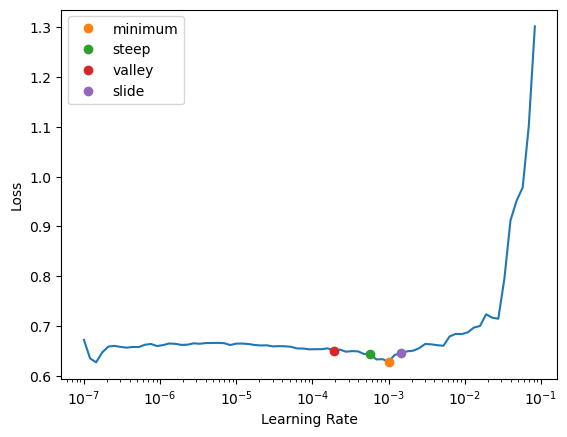

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max=2e-3)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.524900,0.478650,0.851200,0.772059,00:10


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=5.246321597951464e-06, steep=1.3065426344993636e-11, valley=4.974410330760293e-06, slide=1.1716092558344826e-05)

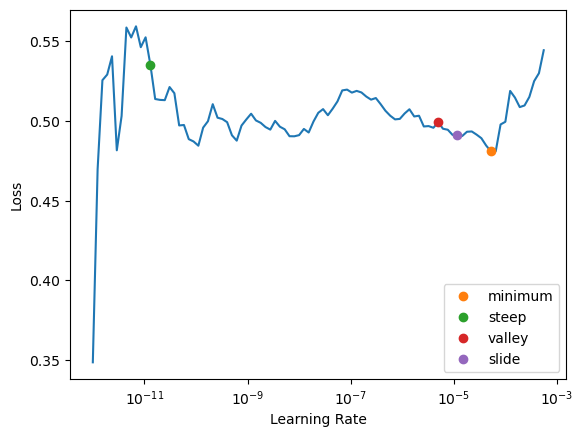

In [ ]:
learn.unfreeze()
learn.lr_find(start_lr=1e-12, end_lr=2e-3, suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(2, lr_max=slice(2e-5, 2e-4))

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.471601,0.478367,0.828614,0.718137,00:18
1,0.288948,0.314919,0.898601,0.857843,00:18


In [ ]:
learn.show_results(learner=learn, max_n=5)

,text,target,prediction
0,"He said the foodservice pie business doesn 't fit the company's long-term growth strategy. "" The foodservice pie business does not fit our long-term growth strategy.",1,1
1,"Morgan Stanley raised its rating on the beverage maker to "" overweight "" from "" equal-weight "" saying in part that pricing power with its bottlers should improve in 2004. Morgan Stanley raised its rating on the company to "" overweight "" from "" equal-weight, "" saying the beverage maker's pricing power with bottlers should improve in 2004.",1,1
2,The 12-nation currency has risen by 33 percent against the dollar over the past 15 months. The euro is up 9 percent against the dollar in the past six weeks.,1,1
3,"A nationally board certified teacher with a master's degree, Kelley makes a salary of $ 65,000 in his 30th year. A nationally board certified teacher with a master's degree, Kelley, in his 30th year teaching, makes $ 65,000.",1,1
4,"Gamarekian told The News she remembers only the woman's first name - and refused to reveal it. She told the New York Daily News she remembers only the intern's first name, which she refused to reveal.",1,1


### Evaluate

How did we do?

In [ ]:
val_res = learn.validate()

In [ ]:
val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics):
    val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'loss': 0.31491944193840027,
 'f1_score': 0.8986013986013986,
 'accuracy': 0.8578431606292725}

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
print(preds.shape, targs.shape, losses.shape)
print(losses.mean(), accuracy(preds, targs))

torch.Size([408, 2]) torch.Size([408]) torch.Size([408])
TensorBase(0.3149) TensorBase(0.8578)


### Inference

Let's do **item inference** on an example from our test dataset

In [ ]:
raw_test_df = pd.DataFrame(raw_datasets[test_ds_name], columns=list(raw_datasets[test_ds_name].features.keys()))
raw_test_df.head(10)

,sentence1,sentence2,label,idx
0,"PCCW 's chief operating officer , Mike Butcher , and Alex Arena , the chief financial officer , will report directly to Mr So .",Current Chief Operating Officer Mike Butcher and Group Chief Financial Officer Alex Arena will report to So .,1,0
1,The world 's two largest automakers said their U.S. sales declined more than predicted last month as a late summer sales frenzy caused more of an industry backlash than expected .,Domestic sales at both GM and No. 2 Ford Motor Co. declined more than predicted as a late summer sales frenzy prompted a larger-than-expected industry backlash .,1,1
2,"According to the federal Centers for Disease Control and Prevention ( news - web sites ) , there were 19 reported cases of measles in the United States in 2002 .",The Centers for Disease Control and Prevention said there were 19 reported cases of measles in the United States in 2002 .,1,2
3,A tropical storm rapidly developed in the Gulf of Mexico Sunday and was expected to hit somewhere along the Texas or Louisiana coasts by Monday night .,A tropical storm rapidly developed in the Gulf of Mexico on Sunday and could have hurricane-force winds when it hits land somewhere along the Louisiana coast Monday night .,0,3
4,The company didn 't detail the costs of the replacement and repairs .,But company officials expect the costs of the replacement work to run into the millions of dollars .,0,4
5,"The settling companies would also assign their possible claims against the underwriters to the investor plaintiffs , he added .","Under the agreement , the settling companies will also assign their potential claims against the underwriters to the investors , he added .",1,5
6,Air Commodore Quaife said the Hornets remained on three-minute alert throughout the operation .,Air Commodore John Quaife said the security operation was unprecedented .,0,6
7,"A Washington County man may have the countys first human case of West Nile virus , the health department said Friday .",The countys first and only human case of West Nile this year was confirmed by health officials on Sept . 8 .,1,7
8,Moseley and a senior aide delivered their summary assessments to about 300 American and allied military officers on Thursday .,General Moseley and a senior aide presented their assessments at an internal briefing for American and allied military officers at Nellis Air Force Base in Nevada on Thursday .,1,8
9,"The broader Standard & Poor 's 500 Index < .SPX > was 0.46 points lower , or 0.05 percent , at 997.02 .","The technology-laced Nasdaq Composite Index .IXIC was up 7.42 points , or 0.45 percent , at 1,653.44 .",0,9


In [ ]:
learn.blurr_predict(raw_test_df.iloc[9].to_dict())

[(('0',), (#1) [tensor(0)], (#1) [tensor([0.9258, 0.0742])])]

Let's do **batch inference** on the entire test dataset

In [ ]:
test_dl = dls.test_dl(raw_datasets[test_ds_name])
preds = learn.get_preds(dl=test_dl)
preds

(tensor([[0.0170, 0.9830],
         [0.0159, 0.9841],
         [0.0083, 0.9917],
         ...,
         [0.1388, 0.8612],
         [0.0077, 0.9923],
         [0.3099, 0.6901]]),
 None)

## High-level API

With the high-level API, we can create our DataBlock, DataLoaders, and Blearner in one line of code

In [ ]:
#hide
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
dl_kwargs = {'bs': bsz, 'val_bs': val_bsz}
learn_kwargs = { 'metrics': task_metrics }

learn = BlearnerForSequenceClassification.from_dataframe(raw_df, pretrained_model_name, 
                                                         text_attr=task_inputs, label_attr=task_target,
                                                         dl_kwargs=dl_kwargs, learner_kwargs=learn_kwargs)

In [ ]:
learn.fit_one_cycle(1, lr_max=2e-3)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.502434,0.456194,0.846154,0.764706,00:09


In [ ]:
learn.show_results(learner=learn, max_n=5)

,text,target,prediction
0,"He said the foodservice pie business doesn 't fit the company's long-term growth strategy. "" The foodservice pie business does not fit our long-term growth strategy.",1,1
1,"Terri Schiavo, 39, underwent the procedure at the Tampa Bay area hospice where she has been living for several years, said her father, Bob Schindler. The tube was removed Wednesday from Terri Schiavo, 39, at the Tampa Bay-area hospice where she has lived for several years.",1,1
2,Sun Microsystems Inc. on Thursday said it had added 100 new third-party systems and 100 new components to its Hardware Compatibility List for the Solaris x86 operating system Platform Edition. The vendor has added 100 new third-party systems and 100 new components to the operating system's Hardware Compatibility List ( HCL ).,0,1
3,""" I think it's going to be a close vote, but I think the grant proposal is going to win, "" McConnell said. "" I think it's going to be a close vote, but I think the grant proposal's going to win, "" said Sen. Mitch McConnell, assistant majority leader.",1,1
4,""" We are committed to helping the Iraqi people get on the path to a free society, "" Rumsfeld said in a speech to the Council on Foreign Relations. "" We are committed to helping the Iraqi people get on the path to a free society, "" he said.",1,1


## Summary

The general flow of this notebook was inspired by Zach Mueller's "[Text Classification with Transformers](https://walkwithfastai.com/nlp.external.transformers-glue)" example that can be found in the wonderful [Walk With Fastai docs](https://walkwithfastai.com/).  Take a look there for another approach to working with fast.ai and Hugging Face on GLUE tasks.

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted index.ipynb.
